In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py
from utils import read_excel,read_excel_predict,create_dataStructure,convert_excel_to_hdf,close_dataset,data_encoding
from tables import *

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

def init_dataset():
    
    read_excel()
    store1 = create_dataStructure()
    convert_excel_to_hdf()
    close_dataset()

def set_data():
    
    global complete_data_set,train_labels,test_labels,test_dataset,train_dataset, train_stats, test_stats
    
    rawData_train = pd.read_hdf('dataset.h5', 'data_train/table')
    rawData_test = pd.read_hdf('dataset.h5', 'data_test/table')
   
    train_dataset = rawData_train.copy()
    test_dataset = rawData_test.copy()

    train_dataset = train_dataset.select_dtypes(exclude=['object'])
    test_dataset = test_dataset.select_dtypes(exclude=['object'])

    
    #std_train = train_dataset['estampado_superior_code'].mean())
    #std_test = test_dataset['estampado_inferior_code'].mean()
    
    
    train_dataset.drop(['ref_sap'], axis=1, inplace=True)
    train_dataset.drop(['ref'], axis=1, inplace=True)
    test_dataset.drop(['ref_sap'],  axis=1, inplace=True)
    test_dataset.drop(['ref'], axis=1, inplace=True)

    train_labels = train_dataset.pop('und_ped') 
    test_labels = test_dataset.pop('und_ped') 
    
    frames = [train_dataset, test_dataset]
    complete_data_set = pd.concat(frames) #se usa para sacar la distribución de la muestra completa
    indexes = complete_data_set['index'] #se debe remover el index para no afectar la normalización
    complete_data_set = complete_data_set.drop(['index'], axis=1)
    
    normed_train_data, train_stats = normTrain(complete_data_set) #datos normalizados con base en la distribución
    normed_test_data = normTest(complete_data_set)
    
    normed_train_data = normed_train_data.fillna(0)
    normed_test_data = normed_test_data.fillna(0)

    return normed_train_data,normed_test_data,train_labels,test_labels
    
def set_prediction_data():
    
    data_set = read_excel_predict()
    
    prediction_data = data_set.copy()
    prediction_data = prediction_data.select_dtypes(exclude=['object'])

    if 'talla' in prediction_data.columns:
        prediction_data.drop(['talla'], axis=1, inplace=True)
        
    if 'rango_precio' in prediction_data.columns:
        prediction_data.drop(['rango_precio'], axis=1, inplace=True)

    prediction_data.drop(['ref_sap'], axis=1, inplace=True)
    prediction_data.drop(['ref'], axis=1, inplace=True)

    prediction_data_label = prediction_data.pop('und_ped') 

    #el excel no tiene esa columna, pero el HDF5 si
    #indexes_prediction_data = prediction_data['index'] #se debe remover el index para no afectar la normalización
    #prediction_data = prediction_data.drop(['index'], axis=1)
    
    normed_prediction_data = normPrediction(prediction_data,complete_data_set) #datos normalizados con base en la distribución

    normed_prediction_data = normed_prediction_data.fillna(0)
    
    return normed_prediction_data
    
def normTrain(x):
  
    indexes_train_dataset = train_dataset.pop('index') 

    train_stats = x.describe()
    train_stats = train_stats.transpose()
    
    normed = (train_dataset - train_stats['mean']) / train_stats['std']
    normed = pd.concat([indexes_train_dataset, normed], axis=1, sort=False)
    
    return normed, train_stats

def normPrediction(prediction_data, complete_data_set):
    
    normed = (prediction_data - train_stats['mean']) / train_stats['std']
    #normed = pd.concat([indexes_train_dataset, normed], axis=1, sort=False)
    
    return normed

def normTest(x):

    indexes_test_dataset = test_dataset.pop('index') 
    
    test_stats = x.describe()
    test_stats = test_stats.transpose()
    
    normed = (test_dataset - test_stats['mean']) / test_stats['std']
    normed = pd.concat([indexes_test_dataset, normed], axis=1, sort=False)
    
    return normed

def build_model():
    model = keras.Sequential([
        layers.Dense(20, activation='relu', input_shape=[len(normed_train_data.keys())]),
        layers.Dense(90, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(1)
      ])

    #optimizer = tf.keras.optimizers.RMSprop(0.0005)
    optimizer = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)
    #optimizer = keras.optimizers.SGD(lr=0.005, momentum=0.05, decay=0.0, nesterov=False)
    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


def load_model():
   
    new_model = keras.models.load_model('model_keras.h5')

    optimizer = keras.optimizers.Adam(lr=0.0007, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)
    #optimizer = tf.keras.optimizers.RMSprop(0.0005)
    #optimizer = keras.optimizers.SGD(lr=0.0005, momentum=0.05, decay=0.0, nesterov=False)

    new_model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    #model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return new_model

    
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val Error')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],label = 'Val Error')
    plt.legend()
    plt.show()




In [ ]:
init_dataset()

In [2]:
normed_train_data,normed_test_data,train_labels,test_labels = set_data()


In [3]:
normed_train_data = normed_train_data.loc[:, normed_train_data.columns != 'index']
normed_test_data = normed_test_data.loc[:, normed_test_data.columns != 'index']

In [131]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_168 (Dense)            (None, 20)                800       
_________________________________________________________________
dense_169 (Dense)            (None, 90)                1890      
_________________________________________________________________
dense_170 (Dense)            (None, 10)                910       
_________________________________________________________________
dense_171 (Dense)            (None, 1)                 11        
Total params: 3,611
Trainable params: 3,611
Non-trainable params: 0
_________________________________________________________________


In [132]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.5315141 ],
       [-0.42229697],
       [-0.9071267 ],
       [-0.11512386],
       [-0.05971715],
       [-0.1503559 ],
       [-0.8925822 ],
       [-0.14526743],
       [-0.14278533],
       [-0.32609332]], dtype=float32)


.............................................................................................

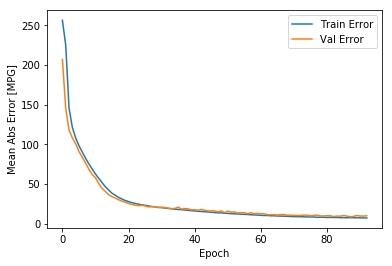

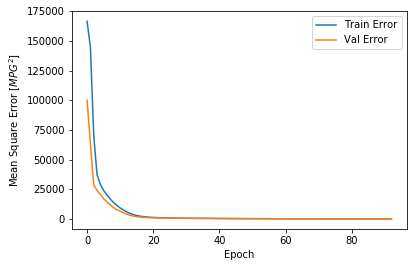

In [133]:
EPOCHS = 100
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, 
                    train_labels, 
                    epochs=EPOCHS,
                    validation_split = 0.02, verbose=0,
                    batch_size= 20,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

Testing set Mean Abs Error:  8.57 MPG
Testing set Loss: 267.96 MPG
ano                        float64
campana                    float64
pagina                     float64
pc_antes                   float64
pc_cat                     float64
upp                        float64
op                         float64
pedidos_real               float64
num_ref                    float64
color_code                 float64
color_mp_code              float64
clasificacion_ll_code      float64
descripcion_code           float64
talla_code                 float64
vehiculo_code              float64
rango_precio_code          float64
uen_code                   float64
segmenta_textil_code       float64
segmenta_edad_code         float64
segmenta_b_i_m_code        float64
es_nvo_code                float64
genero_code                float64
linea_code                 float64
estrateg_exhib_code        float64
categoria_code             float64
clase_prenda_code          float64
silueta_code           

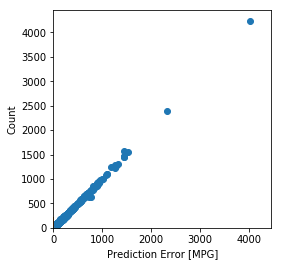

In [134]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("Testing set Loss: {:5.2f} MPG".format(loss))

test_predictions = model.predict(normed_test_data).flatten()
#print(normed_test_data[:3])
#print(test_predictions[:3])
print(normed_test_data.dtypes)
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [14]:
input_data = set_prediction_data()

#print(input_data.T)

predictions = model.predict(input_data).flatten()
print("\n prediction result:", predictions)



 prediction result: [424.50592]


In [13]:
#load model

model = load_model()
input_data = set_prediction_data()
predictions = model.predict(input_data).flatten()

print("\n prediction result:", predictions)


 prediction result: [313.22238]


In [5]:
#save model

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
model.save('model_keras.h5')